In [1]:
from sklearn import datasets
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
iris = datasets.load_iris()
X = iris.data
X = (X-X.mean(axis=0))/X.std(axis=0)
np.corrcoef(X.T)

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

In [3]:
x, y = X[:,2], X[:,3]

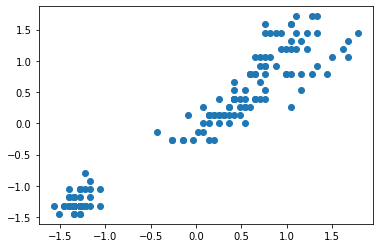

In [4]:
plt.scatter(x,y)
plt.show()

# GP

#### define kernel

In [5]:
def squared_exponential_kernel(a, b, sigma=1, l=1):
    sqdist = np.subtract.outer(a, b)**2
    cov = sigma**2 * np.exp(-0.5 * sqdist / l**2)
    return cov.squeeze()

#### define posterior distribution function

In [6]:
def posterior(x_star, x, y):
    K = squared_exponential_kernel(x, x)+1e-6*np.eye(150)
    K_star = squared_exponential_kernel(x_star, x)
    K_star_star = squared_exponential_kernel(x_star, x_star)
    CK = np.linalg.inv(K).dot(K_star.T)
    mu_new = CK.T.dot(y)
    K_new = K_star_star - K_star.dot(CK)
    return mu_new.squeeze(), K_new.squeeze()

#### draw sample from posterior distribution

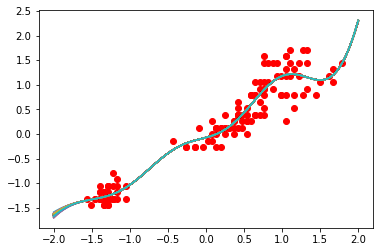

In [7]:
x_star = np.linspace(-2,2,100).reshape(-1,1)
mu_new, K_new = posterior(x_star, x, y)
N = len(x_star)
sample_draw = 100

f_prior = np.random.multivariate_normal(mean=mu_new, cov=K_new, size=sample_draw).T
plt.scatter(x, y, color="red")
plt.plot(x_star, f_prior);